# Section 4: Human-in-the-Loop with LangGraph Primitives

In Section 3, we built a supervisor using `create_agent` that routes queries to specialized sub-agents. However, for some queries like "Whats the status of my recent order", we need to verify the customer's identity first.

In this section, we'll add a **verification layer** using LangGraph primitives that:
- Classifies whether a query needs identity verification
- Pauses execution to collect customer email (HITL)
- Validates the email against our customer database
- Retries up to 3 times if email isn't found
- Skips verification on follow-up questions in the same thread
- Routes to our Section 3 supervisor for the actual query handling

**Key Insight:** We keep the sub-agents simple (`create_agent`), but add sophisticated orchestration with LangGraph.

## 1. Setup

Load environment variables and necessary imports.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## 2. Reuse Sub-Agents from Section 3

We've refactored the Database and Documents agents into the `agents/` directory as factory functions. This allows us to reuse them across sections.

**📦 Note:** These are the exact same agents from Section 3, just imported from a shared module for reusability.

In [ ]:
from agents import create_db_agent, create_docs_agent

# Create sub-agents (same as Section 3)
db_agent = create_db_agent()
docs_agent = create_docs_agent()

### Wrap Sub-Agents as Tools for Supervisor

These tool wrappers are the same as Section 3 - they wrap our sub-agents so the supervisor can call them.

In [ ]:
from langchain_core.tools import tool


# Wrap Database Agent as a tool
@tool
def database_specialist(query: str) -> str:
    """Consult the database specialist for structured data queries.

    This specialist has access to TechHub's operational database and can:
    - Look up order status and tracking information
    - Retrieve customer order history
    - Check product prices and inventory availability

    Use this specialist when the user needs real-time operational data
    (orders, inventory, pricing) rather than product details or policies.

    Args:
        query: The question to ask the database specialist (may be rephrased by supervisor)

    Returns:
        The database specialist's answer based on current database records
    """
    result = db_agent.invoke({"messages": [{"role": "user", "content": query}]})
    return result["messages"][-1].content


# Wrap Documents Agent as a tool
@tool
def documentation_specialist(query: str) -> str:
    """Consult the documentation specialist for product information and policies.

    This specialist has access to TechHub's documentation library and can:
    - Look up product specifications, features, and technical details
    - Explain return, refund, and warranty policies
    - Provide shipping and delivery information
    - Answer questions about product compatibility and setup

    Use this specialist when the user needs detailed product information,
    policy explanations, or guidance (not real-time operational data).

    Args:
        query: The question to ask the documentation specialist (may be rephrased by supervisor)

    Returns:
        The documentation specialist's answer based on product docs and policies
    """
    result = docs_agent.invoke({"messages": [{"role": "user", "content": query}]})
    return result["messages"][-1].content


print("✓ Tool wrappers created")

✓ Tool wrappers created


### Create Supervisor Agent (Same as Section 3)

This supervisor handles routing between database and documentation specialists.

In [4]:
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import MemorySaver

llm = init_chat_model("anthropic:claude-haiku-4-5")

# Create Supervisor Agent
supervisor = create_agent(
    model=llm,
    tools=[database_specialist, documentation_specialist],
    system_prompt="""You are a supervisor for TechHub customer support.

Your role is to understand customer questions and route them to the appropriate specialists:
- Use database_specialist for order status, product prices, and customer order history
- Use documentation_specialist for product specs, policies, and general information

You can use multiple tools if needed to fully answer the question.
Always provide helpful, complete responses to customers.""",
    checkpointer=MemorySaver(),
)

print("✓ Supervisor agent created (compiled graph)")
print("   This is the same supervisor from Section 3!")

✓ Supervisor agent created (compiled graph)
   This is the same supervisor from Section 3!


## 4. Build Verification Layer with LangGraph Primitives

Now we'll add a verification layer that sits **in front of** the supervisor. This layer:
- Checks if verification is needed
- Pauses to collect customer email
- Validates against database
- Retries if email not found
- Skips verification on follow-ups

### State Schema

First, define our custom state that includes customer verification information:

In [6]:
from typing import TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import AnyMessage


# Pydantic model for structured LLM output
class QueryClassification(BaseModel):
    """Classification of whether customer identity verification is required."""

    requires_verification: bool = Field(
        description="True if the query requires knowing customer identity (e.g., 'my orders', 'my account', 'my purchases'). False for general questions (product info, policies, how-to questions)."
    )
    reasoning: str = Field(
        description="Brief explanation of why verification is or isn't needed"
    )


# State schema for the verification graph
class SupervisorState(TypedDict):
    """State for verification graph with HITL.

    Note: 'messages' key is shared with the supervisor subgraph!
    """

    messages: list[AnyMessage]  # Conversation history (shared key)
    customer_id: str | None  # Set after successful verification
    verification_attempts: int  # Counter for retry loop


print("✓ State schema defined")
print("  - messages: shared with supervisor subgraph")
print("  - customer_id: None until verified")
print("  - verification_attempts: for retry logic")

✓ State schema defined
  - messages: shared with supervisor subgraph
  - customer_id: None until verified
  - verification_attempts: for retry logic


### Define Graph Nodes

We'll create 3 nodes:
1. **query_router**: Route based on verification needs (checks state + classifies if needed)
2. **verify_customer**: Pause for email (HITL), lookup in database, retry if needed
3. **supervisor (subgraph)**: The supervisor we created above handles the actual query

In [ ]:
from typing import Literal
from langgraph.types import Command, interrupt
from langgraph.graph import END
from langchain_core.messages import AIMessage, SystemMessage
import sqlite3
from pathlib import Path

DB_PATH = Path("../../data/structured/techhub.db")

print("✓ LangGraph imports ready")

✓ LangGraph imports ready


In [8]:
# Node 1: Query Router
def query_router(
    state: SupervisorState,
) -> Command[Literal["verify_customer", "supervisor"]]:
    """Route based on verification needs.

    Logic:
    1. If customer already verified → supervisor
    2. If query needs verification → verify_customer
    3. Otherwise → supervisor
    """

    # Already verified? Skip to supervisor
    if state.get("customer_id"):
        return Command(goto="supervisor")

    # Not verified - classify if verification is needed
    llm = init_chat_model("anthropic:claude-haiku-4-5")

    # Create structured LLM
    structured_llm = llm.with_structured_output(schema=QueryClassification)

    classification_prompt = """Analyze the user's query to determine if it requires knowing their customer identity.

**Requires identity verification (True):**
- "Show me MY orders"
- "What did I purchase?"
- "MY recent orders"
- "MY account information"
- Any query about "my" or "I" related to orders/purchases

**No verification needed (False):**
- "What's your return policy?"
- "How much does the MacBook Air cost?"
- "What are the specs of the Sony headphones?"
- General product or policy questions
- How-to questions"""

    last_message = state["messages"][-1]

    # Get structured classification
    classification = structured_llm.invoke(
        [
            {"role": "system", "content": classification_prompt},
            {"role": "user", "content": last_message.content},
        ]
    )

    # Route based on structured output
    if classification.requires_verification:
        return Command(goto="verify_customer")
    return Command(goto="supervisor")


print("✓ Node 1: query_router defined (combines routing + classification)")

✓ Node 1: query_router defined (combines routing + classification)


In [ ]:
# Node 2: Verify Customer (KEY HITL NODE)
def verify_customer(
    state: SupervisorState,
) -> Command[Literal["verify_customer", "supervisor", END]]:
    """Verify customer identity with retry support.

    This node demonstrates the key LangGraph HITL pattern:
    - interrupt() MUST come first (code before it will re-run on resume)
    - Retry loop: routes back to itself on failure
    - Max attempts: fails gracefully after 3 tries
    """

    attempts = state.get("verification_attempts", 0)

    # Max 3 attempts - fail gracefully
    if attempts >= 3:
        failure_msg = AIMessage(
            content="I apologize, but I'm unable to verify your account after 3 attempts. "
            "Please contact customer support directly at support@techhub.com or call 1-800-TECH-HUB."
        )
        return Command(update={"messages": state["messages"] + [failure_msg]}, goto=END)

    # Build prompt based on attempt number
    if attempts == 0:
        prompt = "To access your order information, please provide your email address:"
    else:
        prompt = f"⚠️  That email wasn't found in our system. Please verify and try again (Attempt {attempts + 1}/3):"

    # INTERRUPT - MUST come first!
    # Everything before this line will re-run when resuming
    email = interrupt({"prompt": prompt, "type": "email_verification"})

    # Validate email format
    if not email or "@" not in email:
        # Invalid format - retry
        return Command(
            update={"verification_attempts": attempts + 1},
            goto="verify_customer",  # Route back to self
        )

    # Lookup customer in database
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    cursor.execute("SELECT customer_id, name FROM customers WHERE email = ?", (email,))
    result = cursor.fetchone()
    conn.close()

    if not result:
        # Email not found - retry
        return Command(
            update={"verification_attempts": attempts + 1},
            goto="verify_customer",  # Route back to self
        )

    # Success!
    customer_id, customer_name = result
    success_msg = AIMessage(
        content=f"✓ Verified! Welcome back, {customer_name}. How can I help you today?"
    )

    return Command(
        update={
            "customer_id": customer_id,
            "verification_attempts": 0,  # Reset for future use
            "messages": state["messages"] + [success_msg],
        },
        goto="supervisor",  # Proceed to supervisor subgraph
    )


print("✓ Node 2: verify_customer defined (KEY HITL NODE with retry loop)")

✓ Node 2: verify_customer defined (KEY HITL NODE with retry loop)


### Build and Compile the Verification Graph

Now we wire everything together:
- Add all nodes (including supervisor as a subgraph node)
- Set entry point
- Compile with checkpointer (REQUIRED for interrupt())

In [10]:
from langgraph.graph import StateGraph, START

# Build the verification graph
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("query_router", query_router)
workflow.add_node("verify_customer", verify_customer)
workflow.add_node("supervisor", supervisor)  # Add supervisor as subgraph!

# Set entry point
workflow.add_edge(START, "query_router")

# Compile with checkpointer (REQUIRED for interrupt)
verification_graph = workflow.compile(checkpointer=MemorySaver())

print("✓ Verification graph compiled!")
print("\n📊 Graph structure:")
print("   START → query_router → verify_customer → supervisor → END")
print("              ↓                   ↓                          ")
print("      (if verified or       (HITL retry loop)               ")
print("       general query)            ↓                          ")
print("              ↓              supervisor                     ")
print("          supervisor                                        ")

✓ Verification graph compiled!

📊 Graph structure:
   START → query_router → verify_customer → supervisor → END
              ↓                   ↓                          
      (if verified or       (HITL retry loop)               
       general query)            ↓                          
              ↓              supervisor                     
          supervisor                                        


### Visualize the Graph

Let's see what we built:

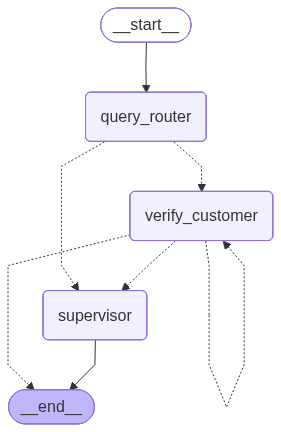

In [11]:
from IPython.display import Image

try:
    display(Image(verification_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not render graph visualization: {e}")
    print("Graph structure:")
    print("  START → query_router")
    print("  query_router → verify_customer | supervisor")
    print("  verify_customer → verify_customer | supervisor | END")
    print("  supervisor → END")

## 5. Test the Verification Graph

Let's test all four scenarios:
1. **General query** - No verification needed
2. **Personal query** - Verification with successful email
3. **Personal query with retry** - Invalid email, then valid email
4. **Follow-up query** - Verification skipped (already verified in thread)

### Scenario 1: General Query (No HITL)

Queries about products or policies don't need customer identity verification.

In [12]:
import uuid
from langchain_core.messages import HumanMessage

# New thread for this scenario
thread_id_1 = str(uuid.uuid4())
config_1 = {"configurable": {"thread_id": thread_id_1}}

print("Query: 'What's your return policy?'")
print("=" * 70)

result = verification_graph.invoke(
    {"messages": [HumanMessage(content="What's your return policy?")]}, config=config_1
)

# Print final response
print("\nResponse:")
print(result["messages"][-1].content)

print("\n💡 Flow: query_router (classifies as NO) → supervisor → END")
print("   No HITL needed for general questions!")

Query: 'What's your return policy?'

Response:
Here's TechHub's return policy:

## Return Windows
- **Unopened Electronics**: 30 days from delivery (full refund with intact original packaging)
- **Opened Electronics**: 14 days from delivery (must be in good working condition with all accessories)
- **All Other Items**: 30 days from delivery (must be in original condition)

## Condition Requirements
To qualify for a return, items must:
- Be in good working condition with no physical damage
- Include all original accessories (power adapters, cables, manuals, etc.)
- Show no signs of misuse or abuse
- Have intact serial numbers and identification labels

## Non-Returnable Items
- Clearance or final sale items
- Digital gift cards
- Downloadable software or digital products
- Items marked "non-returnable" on the product page

## Restocking Fees
No restocking fees apply to defective items, damaged items, unopened items in original packaging, or items under $500.

Do you have a specific prod

### Scenario 2: Personal Query with Successful Verification

Queries about "my orders" require identity verification.

**Test email:** `sarah.chen@gmail.com` (exists in database)

In [36]:
# New thread
thread_id_2 = str(uuid.uuid4())
config_2 = {"configurable": {"thread_id": thread_id_2}}

print("Query: 'Show me my orders'")
print("=" * 70)

# First invocation - will pause at interrupt
result = verification_graph.invoke(
    {"messages": [HumanMessage(content="Show me my orders")]}, config=config_2
)

print("\n⏸️  Graph PAUSED at interrupt()")
print("Prompt:", result.get("__interrupt__", {})[0].value.get("prompt"))
print(
    "\n💡 Flow so far: query_router (classifies as YES) → verify_customer (INTERRUPT)"
)

Query: 'Show me my orders'

⏸️  Graph PAUSED at interrupt()
Prompt: To access your order information, please provide your email address:

💡 Flow so far: query_router (classifies as YES) → verify_customer (INTERRUPT)


In [33]:
result.get("__interrupt__")[0]

Interrupt(value={'prompt': 'To access your order information, please provide your email address:', 'type': 'email_verification'}, id='318bbe605da00bc8781545c389aabef2')

In [23]:
i = result["__interrupt__"][0]

In [26]:
i

Interrupt(value={'prompt': 'To access your order information, please provide your email address:', 'type': 'email_verification'}, id='236e7a8b735ade86ed0c3adf7eb13d69')

In [25]:
i.value

{'prompt': 'To access your order information, please provide your email address:',
 'type': 'email_verification'}

In [ ]:
# Resume with valid email
result = verification_graph.invoke(
    Command(resume="sarah.chen@gmail.com"), config=config_2
)

print("\n✓ Verification successful!")
print("\nFull conversation:")
print("=" * 70)
for msg in result["messages"]:
    msg.pretty_print()

print(
    "\n💡 Complete flow: query_router (classifies as YES) → verify_customer (RESUME) → supervisor → END"
)
print(f"   Customer ID: {result.get('customer_id')}")

### Scenario 3: Personal Query with Retry (Invalid Email)

What happens when the user provides an invalid email? The graph retries!

In [ ]:
# New thread
thread_id_3 = str(uuid.uuid4())
config_3 = {"configurable": {"thread_id": thread_id_3}}

print("Query: 'Show me my recent purchases'")
print("=" * 70)

# First invocation - pauses
result = verification_graph.invoke(
    {"messages": [HumanMessage(content="Show me my recent purchases")]}, config=config_3
)

print("\n⏸️  ATTEMPT 1: Graph paused")
print("Prompt:", result.get("__interrupt__", {}).get("value", {}).get("prompt"))

In [ ]:
# Resume with INVALID email (not in database)
result = verification_graph.invoke(Command(resume="wrong@email.com"), config=config_3)

print("\n⏸️  ATTEMPT 2: Email not found - graph paused again with error message")
print("Prompt:", result.get("__interrupt__", {}).get("value", {}).get("prompt"))
print("\n💡 The node ROUTED BACK TO ITSELF (verify_customer → verify_customer)")
print("   Attempt counter incremented: 0 → 1")

In [ ]:
# Resume with VALID email
result = verification_graph.invoke(
    Command(resume="sarah.chen@gmail.com"), config=config_3
)

print("\n✓ Verification successful on second attempt!")
print("\nFinal response:")
print(result["messages"][-1].content)

print("\n💡 Retry loop in action!")
print("   Attempt 1: wrong@email.com → verify_customer (retry)")
print("   Attempt 2: sarah.chen@gmail.com → supervisor (success)")

### Scenario 4: Follow-up Query (Skip Verification)

Once verified in a thread, follow-up queries skip verification entirely!

In [ ]:
# Use the same thread from Scenario 2 (already verified)
print("Query: 'What about orders from last month?'")
print("Thread ID:", thread_id_2, "(same as Scenario 2)")
print("=" * 70)

result = verification_graph.invoke(
    {"messages": [HumanMessage(content="What about orders from last month?")]},
    config=config_2,  # Reuse config from Scenario 2
)

print("\nResponse:")
print(result["messages"][-1].content)

print("\n💡 Flow: query_router (customer_id exists!) → supervisor → END")
print("   Skipped: classify_query and verify_customer!")
print(f"   Customer ID still in state: {result.get('customer_id')}")

## Key Takeaways

### LangGraph Primitives Demonstrated

1. **StateGraph** - Custom state schema with domain-specific fields
   - `messages`: Shared with supervisor subgraph
   - `customer_id`: Verification status
   - `verification_attempts`: Retry logic control

2. **Nodes** - Modular functions that operate on state
   - `query_router`: Combines routing logic (checks state + classifies)
   - `verify_customer`: HITL with retry loop
   - `supervisor`: Subgraph node (compiled graph from Section 3)

3. **Command** - Combines state updates with routing decisions
   ```python
   return Command(
       update={"customer_id": "CUST-001"},
       goto="supervisor"
   )
   ```

4. **interrupt()** - Pause execution for human input
   - MUST come first in the node function
   - Everything before it re-runs on resume
   - Requires checkpointer to work

5. **Checkpointer** - State persistence across turns
   - Required for `interrupt()` to work
   - Enables conversation memory
   - Automatically propagated to subgraphs

6. **Subgraphs** - Compose graphs as nodes
   - Reuse Section 3's supervisor as a node
   - Shared state keys (`messages`)
   - Clean separation of concerns

### When to Use What

| Pattern | Use When... |
|---------|-------------|
| **`create_agent`** | Simple agents, standard tool loops, straightforward routing |
| **LangGraph StateGraph** | Conditional HITL, custom state, complex orchestration, retry loops |
| **Hybrid (this section!)** | Keep agents simple, add sophisticated orchestration layer |

### Retry Loop Pattern

The `verify_customer` node demonstrates a powerful pattern:
```python
def verify_customer(state):
    attempts = state.get("verification_attempts", 0)
    
    if attempts >= 3:
        return Command(update={...}, goto=END)  # Max attempts
    
    email = interrupt(...)  # Pause for input
    
    if not valid(email):
        return Command(
            update={"verification_attempts": attempts + 1},
            goto="verify_customer"  # RETRY: route back to self!
        )
    
    # Success
    return Command(update={...}, goto="supervisor")
```

### Architecture Benefits

**✅ Separation of Concerns:**
- Verification layer: Handles HITL and customer identity
- Supervisor: Routes to appropriate specialists
- Sub-agents: Execute specific tasks

**✅ Reusability:**
- Section 3's supervisor works unchanged
- Sub-agents remain simple with `create_agent`
- Verification logic isolated in LangGraph layer

**✅ Maintainability:**
- Update verification rules without touching supervisor
- Change max retry attempts in one place
- Clear flow visible in graph structure

### Module 1 Complete! 🎉

You've now built:
1. **Section 1:** Manual tool calling (foundation)
2. **Section 2:** `create_agent` abstraction (simplification)
3. **Section 3:** Multi-agent with supervisor (specialization)
4. **Section 4:** LangGraph primitives + HITL (sophistication) ✅

**Next Steps:**
- **Module 2:** Evaluate this system to find weaknesses
- **Module 3:** Deploy to production with LangGraph Cloud

### Additional Resources

- [LangGraph Documentation](https://docs.langchain.com/oss/python/langgraph)
- [Thinking in LangGraph](https://docs.langchain.com/oss/python/langgraph/thinking-in-langgraph)
- [Subgraphs Guide](https://docs.langchain.com/oss/python/langgraph/use-subgraphs)
- [Human-in-the-Loop Patterns](https://docs.langchain.com/oss/python/langgraph/interrupts)
